In [1]:

external_dat_file <- "granja_10X_CD34.rds"
#external_dat_dir <- "/data2/mito_lineage/Analysis/annotation/output/data/"
#nTop = 25000
workers = 12
assay="ATAC" # RNA, ATAC

exp <- "Flt3l"
SE_f <- "/data/isshamie/mito_lineage/output/annotation/cd34norm/MTblacklist/Flt3l/Flt3l.merged.rds" 
outdir <- "/data/isshamie/mito_lineage/output/annotation/cd34norm/MTblacklist/Flt3l/anchors/ATAC"

k.anchor <- 5

In [2]:
library(future)
plan()
plan("multiprocess", workers = workers)
options(future.globals.maxSize = 8000 * 1024^2)

sequential:
- args: function (..., envir = parent.frame())
- tweaked: FALSE
- call: NULL

In [3]:
library(Seurat)
library(SummarizedExperiment)
library(cowplot)
library(ggplot2)
library(cowplot)
library(patchwork)

Attaching SeuratObject

Loading required package: MatrixGenerics

Loading required package: matrixStats


Attaching package: ‘MatrixGenerics’


The following objects are masked from ‘package:matrixStats’:

    colAlls, colAnyNAs, colAnys, colAvgsPerRowSet, colCollapse,
    colCounts, colCummaxs, colCummins, colCumprods, colCumsums,
    colDiffs, colIQRDiffs, colIQRs, colLogSumExps, colMadDiffs,
    colMads, colMaxs, colMeans2, colMedians, colMins, colOrderStats,
    colProds, colQuantiles, colRanges, colRanks, colSdDiffs, colSds,
    colSums2, colTabulates, colVarDiffs, colVars, colWeightedMads,
    colWeightedMeans, colWeightedMedians, colWeightedSds,
    colWeightedVars, rowAlls, rowAnyNAs, rowAnys, rowAvgsPerColSet,
    rowCollapse, rowCounts, rowCummaxs, rowCummins, rowCumprods,
    rowCumsums, rowDiffs, rowIQRDiffs, rowIQRs, rowLogSumExps,
    rowMadDiffs, rowMads, rowMaxs, rowMeans2, rowMedians, rowMins,
    rowOrderStats, rowProds, rowQuantiles, rowRanges, rowRanks,
    rowSdDif

## Import granja data

In [4]:
unintegrated <- readRDS(SE_f)


In [5]:
ext <- subset(x = unintegrated, subset = orig.ident == "granja_cd34")
curr <- subset(x = unintegrated, subset = orig.ident == exp)


Loading required package: Signac



In [16]:
DefaultAssay(ext) <- assay
DefaultAssay(curr) <- assay

In [7]:
DefaultAssay(unintegrated) <- assay
scatac.list <- c(ext, curr)
reference.list <- scatac.list[c(1,2)]

## Plot batch

In [10]:
unintegrated <- RunTFIDF(unintegrated)
unintegrated <- FindTopFeatures(unintegrated, min.cutoff = 50)
unintegrated <- RunSVD(unintegrated, n = 30, reduction.name = 'lsi', reduction.key = 'LSI_')
unintegrated <- RunUMAP(unintegrated, reduction = 'lsi', dims = 2:30)


Performing TF-IDF normalization

Warning message in RunTFIDF.default(object = GetAssayData(object = object, slot = "counts"), :
“Some features contain 0 total counts”
Running SVD

Scaling cell embeddings

Warning message:
“The default method for RunUMAP has changed from calling Python UMAP via reticulate to the R-native UWOT using the cosine metric
To use Python UMAP via reticulate, set umap.method to 'umap-learn' and metric to 'correlation'
This message will be shown once per session”
21:08:29 UMAP embedding parameters a = 0.9922 b = 1.112

21:08:29 Read 14205 rows and found 29 numeric columns

21:08:29 Using Annoy for neighbor search, n_neighbors = 30

21:08:29 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

21:08:32 Writing NN index file to temp file /tmp/Rtmp8XRd0F

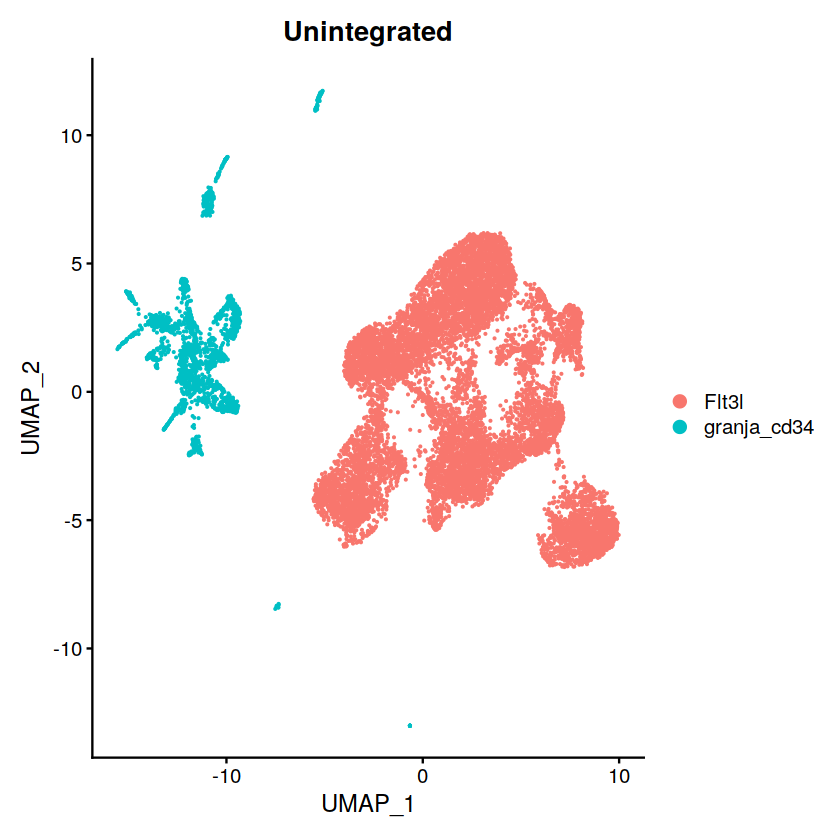

In [11]:
p1 <- DimPlot(unintegrated, group.by = 'orig.ident', pt.size = 0.1) + ggplot2::ggtitle("Unintegrated")

p1

In [ ]:
# find integration anchors between 10x and sci-ATAC
anchors <- FindIntegrationAnchors(
  object.list = list(ext, curr),
  assay = c('ATAC', 'ATAC'),
  k.filter = NA, #anchor.features = peaks.use, Not needed b/c already overlapping peaks
  k.anchor = k.anchor #20, needed if integration not strong enough
)


Computing 2000 integration features



In [ ]:
# integrate data and create a new merged object
integrated <- IntegrateData(
  anchorset = anchors,
  weight.reduction = sample[['lsi']],
  dims = 2:30,
  preserve.order = TRUE
)


In [ ]:
# we now have a "corrected" TF-IDF matrix, and can run LSI again on this corrected matrix
integrated <- RunSVD(
  object = integrated,
  n = 30,
  reduction.name = 'integratedLSI'
)

integrated <- RunUMAP(
  object = integrated,
  dims = 2:30,
  reduction = 'integratedLSI'
)

In [ ]:
p2 <- DimPlot(integrated, group.by = 'orig.ident', pt.size = 0.1) + ggplot2::ggtitle("Integrated")
p1 + p2


In [ ]:
#curr_SE <- readRDS(SE_f)#outdir, paste0(exp, ".merged.rds")))
#ext_SE <- readRDS(SE_f)#outdir, external_dat_file))
# curr_SE[['tech']] <- exp
# ext_SE[['tech']] <-'granja_cd34'

# C1boo <- subset(x = ext_SE, subset = Group %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP"))
# C1boo
# #C1boo <-  ext_SE[[1, 'Group']] %in% c("BM_pDC", "CLP", "CMP", "GMP", "HSC", "LMPP", "MEP", "Monocytes", "MPP")
# #C1boo

# DefaultAssay(C1boo) <- assay
# DefaultAssay(curr_SE) <- assay

#scatac.list <- c(C1boo, curr_SE)


# for (i in 1:length(scatac.list)) {
#     scatac.list[[i]] <- NormalizeData(scatac.list[[i]], verbose = TRUE)
#     scatac.list[[i]] <- FindVariableFeatures(scatac.list[[i]], nfeatures = 2000,
#         verbose = TRUE)
# }
#reference.list <- scatac.list[c(1,2)]


## Integrate anchors

In [11]:
#reference.list <- scatac.list[c(1)]
scatac.anchors <- FindIntegrationAnchors(object.list = reference.list, dims = 1:30,)


Computing 2000 integration features

Scaling features for provided objects

Finding all pairwise anchors

Running CCA

Merging objects

Warning message:
“No filtering performed if passing to data rather than counts”
Finding neighborhoods

Finding anchors

	Found 10836 anchors

Filtering anchors

	Retained 479 anchors



In [12]:
scatac.anchors

An AnchorSet object containing 958 anchors between 2 Seurat objects 
 This can be used as input to IntegrateData.

In [13]:
scatac.integrated <- IntegrateData(anchorset = scatac.anchors, dims = 1:30)

Merging dataset 1 into 2

Warning message:
“No filtering performed if passing to data rather than counts”
Extracting anchors for merged samples

Warning message:
“No filtering performed if passing to data rather than counts”
Finding integration vectors

Finding integration vector weights

Integrating data



## Plot batch and external group on umap

## switch to integrated assay. The variable features of this assay are automatically set during IntegrateData

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”
Saving 6.67 x 6.67 in image

Warning message:
“ggrepel: 4 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


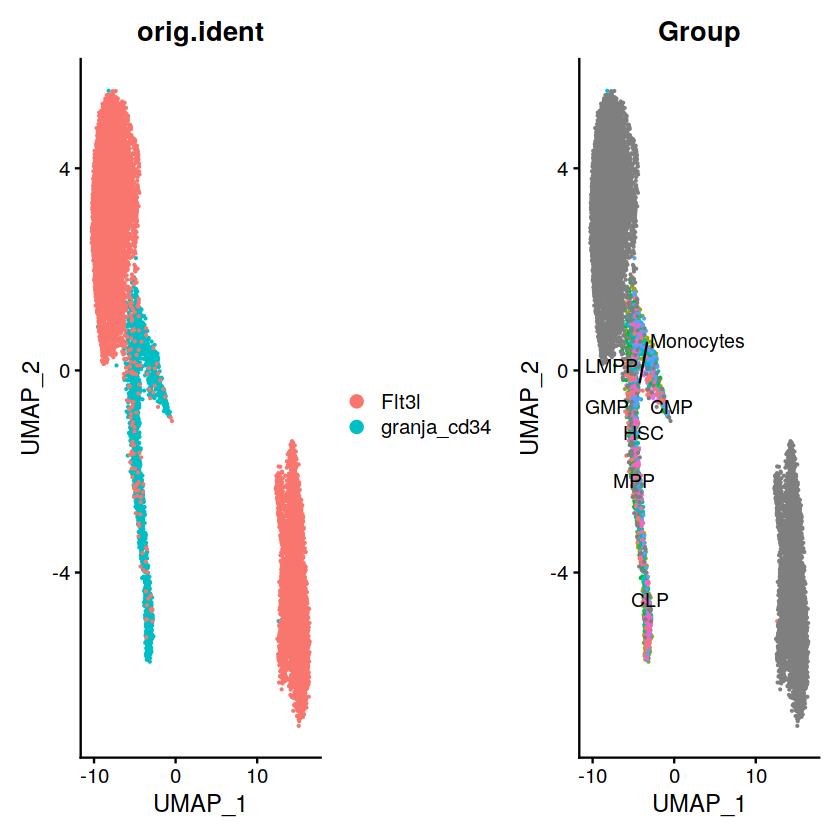

In [20]:

DefaultAssay(scatac.integrated) <- "integrated"
# Run the standard workflow for visualization and clustering
scatac.integrated <- ScaleData(scatac.integrated, verbose = FALSE)
scatac.integrated <- RunPCA(scatac.integrated, npcs = 30, verbose = FALSE)
scatac.integrated <- RunUMAP(scatac.integrated, reduction = "pca", dims = 1:30, verbose = FALSE)
p1 <- DimPlot(scatac.integrated, reduction = "umap", group.by = "orig.ident")
p2 <- DimPlot(scatac.integrated, reduction = "umap", group.by = "Group", label = TRUE, repel = TRUE) +
    NoLegend()
p1 + p2
cowplot::ggsave2(p1+p2, file = file.path(outdir, paste0(exp, ".merged.anchors.labels.png")))

## Transfer labels from reference to sample

In [21]:
scatac.query <- scatac.list[[2]]
scatac.anchors <- FindTransferAnchors(reference = scatac.integrated, query = scatac.query,
    dims = 1:30, reference.reduction = "pca")
predictions <- TransferData(anchorset = scatac.anchors, refdata = scatac.integrated$Group,
    dims = 1:30)
scatac.query <- AddMetaData(scatac.query, metadata = predictions)

Projecting cell embeddings

Finding neighborhoods

Finding anchors

	Found 19357 anchors

Filtering anchors

	Retained 12754 anchors

Finding integration vectors

Finding integration vector weights

Predicting cell labels



In [23]:
table(scatac.query$predicted.id)



      GMP       MEP Monocytes 
        1         2     12006 

In [ ]:
scatac.integrated <- RunUMAP(scatac.integrated, dims = 1:30, reduction = "pca", return.model = TRUE)
scatac.query <- MapQuery(anchorset = scatac.anchors, reference = scatac.integrated, query = scatac.query,
    refdata = list(celltype = "celltype"), reference.reduction = "pca", reduction.model = "umap")

UMAP will return its model

20:40:11 UMAP embedding parameters a = 0.9922 b = 1.112

20:40:11 Read 14205 rows and found 30 numeric columns

20:40:11 Using Annoy for neighbor search, n_neighbors = 30

20:40:11 Building Annoy index with metric = cosine, n_trees = 50

0%   10   20   30   40   50   60   70   80   90   100%

[----|----|----|----|----|----|----|----|----|----|

*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
*
|

20:40:16 Writing NN index file to temp file /tmp/Rtmph9pIkp/fileccd2e48078c

20:40:16 Searching Annoy index using 12 threads, search_k = 3000

20:40:17 Annoy recall = 100%

20:40:19 Commencing smooth kNN distance calibration using 12 threads

20:40:21 Initializing from normalized Laplacian + noise

20:40:22 Commencing optimization for 200 epochs, with 747260 positive edges

20:40:34 Optimization finished

Warning message:
“Element number 1 provided to refdata does not exist in the provided reference object.”


In [ ]:
p1 <- DimPlot(scatac.integrated, reduction = "umap", group.by = "celltype", label = TRUE, label.size = 3,
    repel = TRUE) + NoLegend() + ggtitle("Reference annotations")
p2 <- DimPlot(scatac.query, reduction = "ref.umap", group.by = "predicted.celltype", label = TRUE,
    label.size = 3, repel = TRUE) + NoLegend() + ggtitle("Query transferred labels")
p1 + p2
cowplot::ggsave2(p1+p2, file = file.path(outdir, paste0(exp, ".merged.anchors.sample.labels.png")), width = 1.7, height = 1.7)

In [ ]:
p1 + p2

## Save!

### Save cell labels and integrated signac file

In [ ]:
write.table(scatac.integrated[, "celltype", drop=FALSE], file = file.path(outdir, paste0(exp, ".clusters.csv")), 
            col.names=FALSE,
          row.names=TRUE, quote=FALSE, sep=",")

In [ ]:
saveRDS(scatac.integrated, file.path(outdir, paste0(exp, "scatac.integrated.rds")))#file.path(outdir, "scatac.integrated.rds" ))

# Unimodal UMAP Projection


In [ ]:
scatac.integrated <- RunUMAP(scatac.integrated, dims = 1:30, reduction = "pca", return.model = TRUE)
scatac.query <- MapQuery(anchorset = scatac.anchors, reference = scatac.integrated, query = scatac.query,
    refdata = list(celltype = "celltype"), reference.reduction = "pca", reduction.model = "umap")

In [ ]:
scatac.query <- TransferData(anchorset = scatac.anchors, reference = scatac.integrated, query = scatac.query,
    refdata = list(celltype = "celltype"))
scatac.query <- IntegrateEmbeddings(anchorset = scatac.anchors, reference = scatac.integrated,
    query = scatac.query, new.reduction.name = "ref.pca")
scatac.query <- ProjectUMAP(query = scatac.query, query.reduction = "ref.pca", reference = scatac.integrated,
    reference.reduction = "pca", reduction.model = "umap")


In [ ]:
p1 <- DimPlot(scatac.integrated, reduction = "umap", group.by = "celltype", label = TRUE, label.size = 3,
    repel = TRUE) + NoLegend() + ggtitle("Reference annotations")
p2 <- DimPlot(scatac.query, reduction = "ref.umap", group.by = "predicted.celltype", label = TRUE,
    label.size = 3, repel = TRUE) + NoLegend() + ggtitle("Query transferred labels")
p1 + p2